<center style="
               padding: 3rem 2rem;
               border: 3px solid #32d9a7;
               border-radius: 15px;
               ">
    <h1 style="color: #32d9a7;">CNN with Squeeze-Excitation Block + Comparison</h1>
    <h2 style="color: #32d9a7;">Pytorch Lightning Trainer ⚡️</h2>
    <a href="https://kaggle.com/shreydan" style="
                                                 padding: 1rem 2rem;
                                                 background-color: #32d9a7;
                                                 color: white;
                                                 border-radius: 25px;
                                                 text-decoration: none;
                                                 ">@shreydan</a>
</center>

# **Imports**
___

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(5)

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np
import torch
import torch.nn as nn

In [4]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torchmetrics

# **Preparing Data**
___

In [5]:
ds_path = Path('../input/animals10/raw-img')

In [6]:
images = [path for path in ds_path.glob('*/*')]
classes = [path.parent.stem for path in images]
len(images), len(classes)

(26179, 26179)

In [7]:
translate = {"cane": "dog", 
             "cavallo": "horse", 
             "elefante": "elephant",
             "farfalla": "butterfly",
             "gallina": "chicken",
             "gatto": "cat", 
             "mucca": "cow", 
             "pecora": "sheep", 
             "scoiattolo": "squirrel",
             "ragno": "spider"
            }
translated_classes = [translate[label] for label in classes]

In [8]:
Counter(translated_classes)

Counter({'horse': 2623,
         'sheep': 1820,
         'elephant': 1446,
         'cat': 1668,
         'squirrel': 1862,
         'chicken': 3098,
         'spider': 4821,
         'cow': 1866,
         'dog': 4863,
         'butterfly': 2112})

In [9]:
df = pd.DataFrame({'path': images,'class': translated_classes})
df['class'] = df['class'].astype('category')
df['label'] = df['class'].cat.codes

class_labels = dict(zip(range(10), df['class'].cat.categories))

In [10]:
df.head(10)

,path,class,label
0,../input/animals10/raw-img/cavallo/OIP-mdvOxIW...,horse,6
1,../input/animals10/raw-img/cavallo/OIP-TPYKs3X...,horse,6
2,../input/animals10/raw-img/cavallo/OIP-jlVRrok...,horse,6
3,../input/animals10/raw-img/cavallo/OIP-F4QVZ71...,horse,6
4,../input/animals10/raw-img/cavallo/OIP-UFtUZnX...,horse,6
5,../input/animals10/raw-img/cavallo/OIP-irWuWeI...,horse,6
6,../input/animals10/raw-img/cavallo/OIP-Y-hB14A...,horse,6
7,../input/animals10/raw-img/cavallo/OIP-KqeKmYf...,horse,6
8,../input/animals10/raw-img/cavallo/OIP-s40xdXS...,horse,6
9,../input/animals10/raw-img/cavallo/OIP-4k_sWoJ...,horse,6


In [11]:
class_labels

{0: 'butterfly',
 1: 'cat',
 2: 'chicken',
 3: 'cow',
 4: 'dog',
 5: 'elephant',
 6: 'horse',
 7: 'sheep',
 8: 'spider',
 9: 'squirrel'}

## **10% Test Data**

In [12]:
train, test = train_test_split(df, test_size=0.1, shuffle=True, stratify=df['label'])
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)
len(train), len(test)

(23561, 2618)

In [13]:
train.head(10)

,path,class,label
0,../input/animals10/raw-img/pecora/OIP-wfqs6G73...,sheep,7
1,../input/animals10/raw-img/gatto/934.jpeg,cat,1
2,../input/animals10/raw-img/gatto/1883.jpeg,cat,1
3,../input/animals10/raw-img/scoiattolo/OIP--zMa...,squirrel,9
4,../input/animals10/raw-img/cane/OIP-vSA4aXqZUF...,dog,4
5,../input/animals10/raw-img/farfalla/OIP-XLZj3H...,butterfly,0
6,../input/animals10/raw-img/scoiattolo/OIP-voYm...,squirrel,9
7,../input/animals10/raw-img/pecora/OIP-BEMyll3b...,sheep,7
8,../input/animals10/raw-img/gallina/236.jpeg,chicken,2
9,../input/animals10/raw-img/cane/OIP-Nth0jEidGs...,dog,4


# **Custom Dataset**
___

In [14]:
class AnimalsDataset:
    def __init__(self, df, albumentations=None):
        self.paths = df['path'].values
        self.labels = df['label'].values
        if albumentations is None:
            self.albumentations = A.Compose(
            [
                A.SmallestMaxSize(max_size=320),
                A.CenterCrop(height=224, width=224),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()
            ])
        else:
            self.albumentations = albumentations
            
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        sample = self.paths[idx]
        sample = Image.open(sample).convert(mode='RGB')
        sample = np.array(sample)
        sample = self.albumentations(image=sample)['image']
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        return (sample, label)
        

# **Visualization**
___

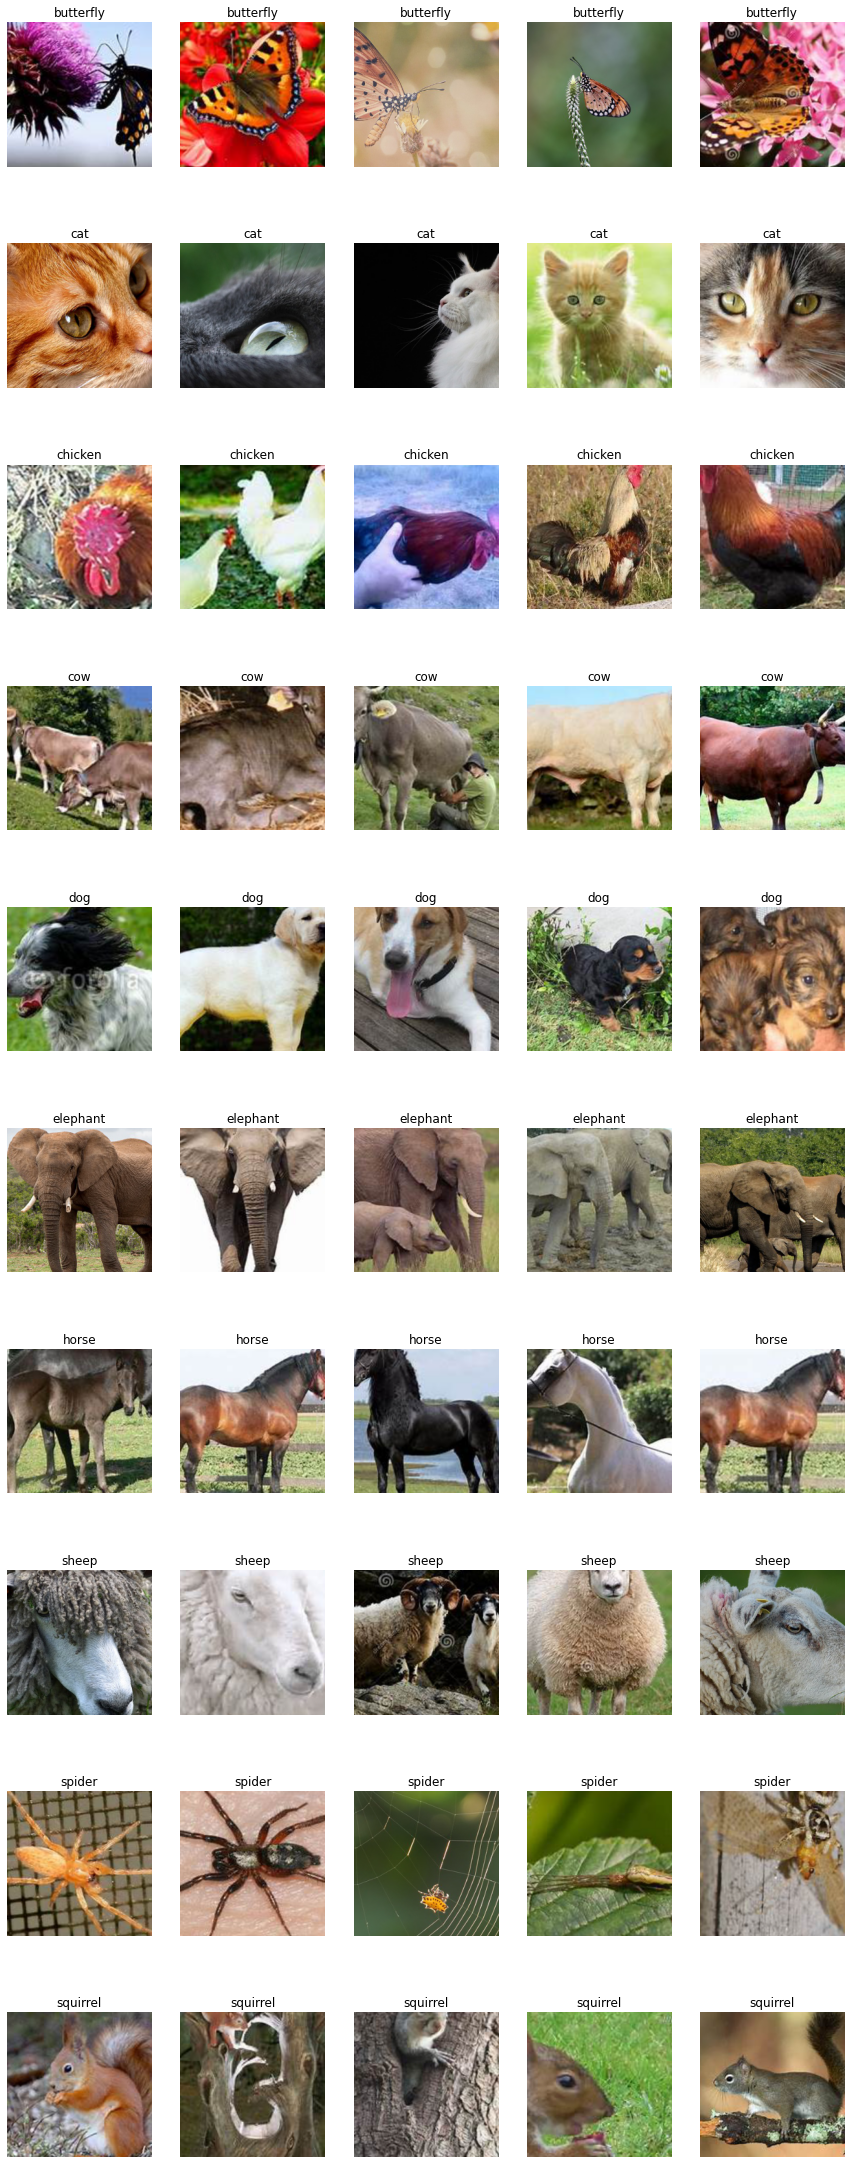

In [15]:
five_from_each = test.groupby('class').apply(lambda s: s.sample(5)).reset_index(drop=True)
five_from_each_ds = AnimalsDataset(five_from_each, A.Compose(
            [
                A.SmallestMaxSize(max_size=300),
                A.CenterCrop(height=224, width=224),
                ToTensorV2()
            ])
  
                                  )

figure = plt.figure(figsize=(15,40))
for i in range(1,len(five_from_each_ds)+1):
    img = five_from_each_ds[i-1][0].permute(1,2,0)
    label = class_labels[five_from_each_ds[i-1][1].item()]
    figure.add_subplot(10,5,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

# **Albumentations**
___

In [16]:
train_albumentations = A.Compose(
    [
        A.SmallestMaxSize(max_size=320),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=224, width=224),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

# **CNN Model with 2 Squeeze-Excitation Blocks**
___

![Squeeze-Excitation Block Architecture](https://i.imgur.com/WFBLllK.png)

In [17]:
class SENet(pl.LightningModule):
    def __init__(self, in_channels=3, num_classes=10, ratio=16):
        super(SENet, self).__init__()
        self.ratio = ratio
        self.in_channels = 3
        self.num_classes= num_classes
        
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(self.in_channels,16,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.se_block1 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(32, 32//self.ratio, 1),
            nn.SiLU(),
            nn.Conv2d(32//self.ratio, 32, 1),
            nn.Sigmoid()
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64,128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.se_block2 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(128, 128//self.ratio, 1),
            nn.SiLU(),
            nn.Conv2d(128//self.ratio, 128, 1),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*12*12, 256),
            nn.Dropout(0.3),
            nn.Linear(256, self.num_classes)
        )
        
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = x * self.se_block1(x)
        x = self.conv_block2(x)
        x = x * self.se_block2(x)
        x = self.classifier(x)
        return x
    
    
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=4e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3,gamma=0.1)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        
        preds = self(x)
        
        loss = self.loss_fn(preds, y)
        self.train_acc(torch.argmax(preds, dim=1), y)
        
        self.log('train_loss', loss.item(), on_epoch=True)
        self.log('train_acc', self.train_acc, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        
        x,y = batch
        
        preds = self(x)
        
        loss = self.loss_fn(preds, y)
        self.val_acc(torch.argmax(preds, dim=1), y)
        
        self.log('val_loss', loss.item(), on_epoch=True)
        self.log('val_acc', self.val_acc, on_epoch=True)
        
    def test_step(self, batch, batch_idx):
        
        x,y = batch
        preds = self(x)
        self.test_acc(torch.argmax(preds, dim=1), y)
        
        self.log('test_acc', self.test_acc, on_epoch=True)

In [18]:
m = SENet()
x = torch.rand(1,3,224,224)
m(x).shape

torch.Size([1, 10])

# **CNN Model without 2 Squeeze-Excitation Blocks**
___


In [19]:
class WithoutSENet(pl.LightningModule):
    def __init__(self, in_channels=3, num_classes=10, ratio=16):
        super(WithoutSENet, self).__init__()
        self.ratio = ratio
        self.in_channels = 3
        self.num_classes= num_classes
        
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(self.in_channels,16,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64,128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*12*12, 256),
            nn.Dropout(0.3),
            nn.Linear(256, self.num_classes)
        )
        
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        return x
    
    
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=4e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3,gamma=0.1)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        
        preds = self(x)
        
        loss = self.loss_fn(preds, y)
        self.train_acc(torch.argmax(preds, dim=1), y)
        
        self.log('train_loss', loss.item(), on_epoch=True)
        self.log('train_acc', self.train_acc, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        
        x,y = batch
        
        preds = self(x)
        
        loss = self.loss_fn(preds, y)
        self.val_acc(torch.argmax(preds, dim=1), y)
        
        self.log('val_loss', loss.item(), on_epoch=True)
        self.log('val_acc', self.val_acc, on_epoch=True)
        
    def test_step(self, batch, batch_idx):
        
        x,y = batch
        preds = self(x)
        self.test_acc(torch.argmax(preds, dim=1), y)
        
        self.log('test_acc', self.test_acc, on_epoch=True)

In [20]:
m = WithoutSENet()
x = torch.rand(1,3,224,224)
m(x).shape

torch.Size([1, 10])

# **Dataloaders for train, test, val**
___

In [21]:
train_df, val_df = train_test_split(train, test_size=0.1, shuffle=True, stratify=train['label'])


train_ds = AnimalsDataset(train_df, albumentations=train_albumentations)
val_ds = AnimalsDataset(val_df)
test_ds = AnimalsDataset(test)

train_dataloader = torch.utils.data.DataLoader(train_ds,batch_size=32,num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=32,num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=64, num_workers=2)

# **Training for model with Squeeze-Excitation Blocks**
___

- Early Stopping: patience = 5, monitoring val_loss
- 30 Epochs Max
- Learning Rate Scheduler: StepLR: step_size: 3, gamma: 0.1

In [22]:
model = SENet()
trainer = pl.Trainer(accelerator='gpu', 
                     callbacks=[
                         EarlyStopping(monitor="val_loss", 
                                       mode="min",
                                       patience=5,
                                      )
                     ],
                     max_epochs = 30
                    )

trainer.fit(model, train_dataloader, val_dataloader)
metrics = trainer.logged_metrics
trainer.test(model, test_dataloader)

SElogs = {
    'train_loss': metrics['train_loss_epoch'].item(),
    'val_loss': metrics['val_loss'].item(),
    'train_acc': metrics['train_acc_epoch'].item(),
    'val_acc': metrics['val_acc'].item()
}

print(f"Train Loss: {SElogs['train_loss']} | Train Accuracy: {SElogs['train_acc']}")
print(f"Val Loss: {SElogs['val_loss']} | Val Accuracy: {SElogs['val_acc']}")

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4709702134132385     │
└───────────────────────────┴───────────────────────────┘

Train Loss: 1.6790611743927002 | Train Accuracy: 0.41275230050086975
Val Loss: 1.5348142385482788 | Val Accuracy: 0.4666949510574341


# **Training for model WITHOUT Squeeze-Excitation Blocks**
___

- Early Stopping: patience = 5, monitoring val_loss
- 30 Epochs Max
- Learning Rate Scheduler: StepLR: step_size: 3, gamma: 0.1

In [23]:
model = WithoutSENet()
trainer = pl.Trainer(accelerator='gpu', 
                     callbacks=[
                         EarlyStopping(monitor="val_loss", 
                                       mode="min",
                                       patience=5,
                                      )
                     ],
                     max_epochs = 30
                    )

trainer.fit(model, train_dataloader, val_dataloader)
metrics = trainer.logged_metrics
trainer.test(model, test_dataloader)

logs = {
    'train_loss': metrics['train_loss_epoch'].item(),
    'val_loss': metrics['val_loss'].item(),
    'train_acc': metrics['train_acc_epoch'].item(),
    'val_acc': metrics['val_acc'].item()
}

print(f"Train Loss: {logs['train_loss']} | Train Accuracy: {logs['train_acc']}")
print(f"Val Loss: {logs['val_loss']} | Val Accuracy: {logs['val_acc']}")

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3525592088699341     │
└───────────────────────────┴───────────────────────────┘

Train Loss: 1.9597934484481812 | Train Accuracy: 0.31409168243408203
Val Loss: 1.8777817487716675 | Val Accuracy: 0.3491726815700531


# **Comparison**
___

In [24]:
print("\nCOMPARISON\n-------------\n")
keys = list(SElogs.keys())
log_list = list(zip(SElogs.values(), logs.values()))
for i, (se, not_se) in enumerate(log_list):
    print(keys[i])
    print(f"with SE-blocks: {se} | without: {not_se}")
    if 'loss' in keys[i]:
        print(f"better {'with' if se<not_se else 'without'} Squeeze-Excitation blocks")
    else:
        print(f"better {'with' if se>not_se else 'without'} Squeeze-Excitation blocks")
    print('\n_____________\n')


COMPARISON
-------------

train_loss
with SE-blocks: 1.6790611743927002 | without: 1.9597934484481812
better with Squeeze-Excitation blocks

_____________

val_loss
with SE-blocks: 1.5348142385482788 | without: 1.8777817487716675
better with Squeeze-Excitation blocks

_____________

train_acc
with SE-blocks: 0.41275230050086975 | without: 0.31409168243408203
better with Squeeze-Excitation blocks

_____________

val_acc
with SE-blocks: 0.4666949510574341 | without: 0.3491726815700531
better with Squeeze-Excitation blocks

_____________



___

# **Thank You! ✨️**

For taking the time to check out my notebook! 

Would really appreciate your feedback! Feel free to leave a comment 💬️


<center><img src="https://img.shields.io/badge/Upvote-If%20you%20like%20my%20work-07b3c8?style=for-the-badge&logo=kaggle" /></center>



___